# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lmerTest’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:lme4’:

    lmer


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    step


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/p

## Set file locations

In [3]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  phyDist expanded table table 

In [4]:
%%R 
setwd(workDir)
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)

NAMdist = read.table(NAMFile, header = TRUE)

In [5]:
%%R
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

### Use melt to create a dataframe with species by species comparisons that will later be compared with plot by plot unifrac distances

Notes: inefficient use of space, consider dropping records above the diagonal of the distance matrix

In [6]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head


  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


# Import phyloseq object and calculate unifrac distances

In [7]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)



physeq.Full = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [8]:
%%R
physeq.Full
physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")

physeq.Plant = subset_samples(physeq.Full, Plant != "BARE")
sd = sample_data(physeq.Plant)

## Calculate w-Unifrac distances

In [9]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.Plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [10]:
%%R
as.matrix(wunif.dist) %>% head

                  sample5-1.22_Nneg sample6-4.12_Npos sample4-1.03_Npos
sample5-1.22_Nneg         0.0000000         0.1823763         0.1619849
sample6-4.12_Npos         0.1823763         0.0000000         0.1926361
sample4-1.03_Npos         0.1619849         0.1926361         0.0000000
sample5-2.06_Npos         0.1673805         0.1665474         0.1890132
sample5-4.08_Npos         0.1653478         0.1263513         0.1806785
sample5-4.28_Npos         0.1279704         0.1657647         0.1559275
                  sample5-2.06_Npos sample5-4.08_Npos sample5-4.28_Npos
sample5-1.22_Nneg         0.1673805         0.1653478         0.1279704
sample6-4.12_Npos         0.1665474         0.1263513         0.1657647
sample4-1.03_Npos         0.1890132         0.1806785         0.1559275
sample5-2.06_Npos         0.0000000         0.1319154         0.1404844
sample5-4.08_Npos         0.1319154         0.0000000         0.1368578
sample5-4.28_Npos         0.1404844         0.1368578         0.

In [11]:
%%R
ud.m = melt(as.matrix(wunif.dist))
head(ud.m) %>% print
dim(ud.m) %>% print
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")

#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")



               Var1              Var2     value
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.0000000
2 sample6-4.12_Npos sample5-1.22_Nneg 0.1823763
3 sample4-1.03_Npos sample5-1.22_Nneg 0.1619849
4 sample5-2.06_Npos sample5-1.22_Nneg 0.1673805
5 sample5-4.08_Npos sample5-1.22_Nneg 0.1653478
6 sample5-4.28_Npos sample5-1.22_Nneg 0.1279704
[1] 30276     3
              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1823763   Oh7B
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1619849  SETFA
4 sample5-2.06_Npos sample5-1.22_Nneg   0.1673805   MS71
5 sample5-4.08_Npos sample5-1.22_Nneg   0.1653478   MS71
6 sample5-4.28_Npos sample5-1.22_Nneg   0.1279704 75-062
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1823763   Oh7B 75-062
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1619849  SETFA 

* How to remove duplicates, ie values above the diagonal?  Possibly a loop that checks if var1-var2 = var2-var1, then remove.

# Join with plant phylogenetic distance, graph phylogenetic distance vs w-unifrac

In [12]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 


                  PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
30271 sample7-4.14_Nneg sample8-3.03_Nneg   0.2374160  SORBI  ELCOR SORBI-ELCOR
30272 sample8-2.07_Npos sample8-3.03_Nneg   0.1533796  ELCOR  ELCOR ELCOR-ELCOR
30273 sample3-4.18_Npos sample8-3.03_Nneg   0.2501898  ABUTH  ELCOR ABUTH-ELCOR
30274 sample8-4.04_Npos sample8-3.03_Nneg   0.2287269   Mo18  ELCOR  Mo18-ELCOR
30275 sample8-2.25_Npos sample8-3.03_Nneg   0.1726143    Ki3  ELCOR   Ki3-ELCOR
30276 sample8-3.03_Nneg sample8-3.03_Nneg   0.0000000  ELCOR  ELCOR ELCOR-ELCOR
      phy_Dist
30271  0.04779
30272  0.00000
30273  0.36639
30274  0.05090
30275  0.05090
30276  0.00000


[1] 30276     7
[1] 30102     7


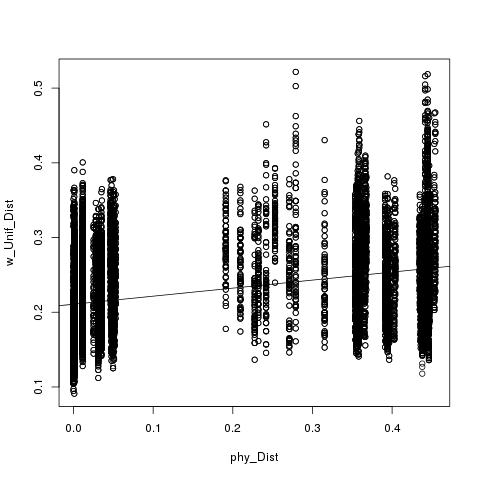

In [13]:
%%R
dim(Dist) %>% print
D.s = filter(Dist, PlotA != PlotB)

dim(D.s) %>% print
plot(w_Unif_Dist~phy_Dist, data = D.s)
m = lm(w_Unif_Dist~phy_Dist, data = D.s)
abline(m)

# Mantel test of phylogenetic distance and microbial community distance

## Set up distance matrices

In [14]:
%%R
head(Dist) %>% print
#Remove NAs to trim dataset
Temp = Dist[!is.na(Dist$phy_Dist),]
dim(Temp) %>% print

#Seperate unifrac and phylogenetic distances retaining plot IDs
U = Temp[,c(1,2,3)]
Phy = Temp[,c(1,2,7)]

#Re-cast longform to wide form.  
Udist = acast(U, PlotA~PlotB)


Phydist = acast(Phy, PlotA~PlotB)


#Convert to distance matrices
Phydist = as.matrix(Phydist) %>% dist()
Udist = as.matrix(Udist) %>% dist()

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using w_Unif_Dist as value column: use value.var to override.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using phy_Dist as value column: use value.var to override.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062 75-062-75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1823763   Oh7B 75-062   Oh7B-75-062
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1619849  SETFA 75-062  SETFA-75-062
4 sample5-2.06_Npos sample5-1.22_Nneg   0.1673805   MS71 75-062   MS71-75-062
5 sample5-4.08_Npos sample5-1.22_Nneg   0.1653478   MS71 75-062   MS71-75-062
6 sample5-4.28_Npos sample5-1.22_Nneg   0.1279704 75-062 75-062 75-062-75-062
  phy_Dist
1       NA
2       NA
3       NA
4       NA
5       NA
6       NA
[1] 28884     7


In [15]:
%%R
#check congruence
Phydist %>% as.matrix %>% tail


                  sample1-1.27_Nneg sample1-1.27_Npos sample1-2.23_Nneg
sample8-4.04_Nneg          4.990224          4.990224          4.990224
sample8-4.04_Npos          4.990224          4.990224          4.990224
sample8-4.07_Nneg          4.990224          4.990224          4.990224
sample8-4.07_Npos          4.990224          4.990224          4.990224
sample8-4.23_Nneg          4.990224          4.990224          4.990224
sample8-4.23_Npos          4.990224          4.990224          4.990224
                  sample1-2.23_Npos sample1-3.08_Nneg sample1-3.08_Npos
sample8-4.04_Nneg          4.990224          4.990224          4.990224
sample8-4.04_Npos          4.990224          4.990224          4.990224
sample8-4.07_Nneg          4.990224          4.990224          4.990224
sample8-4.07_Npos          4.990224          4.990224          4.990224
sample8-4.23_Nneg          4.990224          4.990224          4.990224
sample8-4.23_Npos          4.990224          4.990224          4

In [16]:
%%R
Udist %>% as.matrix %>% tail

                  sample1-1.27_Nneg sample1-1.27_Npos sample1-2.23_Nneg
sample8-4.04_Nneg         1.2208073         1.0072890         1.1461774
sample8-4.04_Npos         1.1260161         0.9113136         1.0470715
sample8-4.07_Nneg         1.0216156         0.4900990         0.8003827
sample8-4.07_Npos         0.8085298         0.3561234         0.5645017
sample8-4.23_Nneg         1.1438214         0.7084515         0.9674597
sample8-4.23_Npos         0.8505838         0.7220030         0.8272677
                  sample1-2.23_Npos sample1-3.08_Nneg sample1-3.08_Npos
sample8-4.04_Nneg         1.0943962         1.2100326         1.2218342
sample8-4.04_Npos         0.9926021         1.1129286         1.1205807
sample8-4.07_Nneg         0.6763001         0.8829666         0.8990824
sample8-4.07_Npos         0.4300802         0.6324696         0.6619874
sample8-4.23_Nneg         0.8641335         1.0588213         1.0628385
sample8-4.23_Npos         0.8231480         0.8882494         0.

## Mantel test, including all plants and maize with 0.01 distance between

In [17]:
%%R
M1 = mantel(Phydist, Udist, method="pearson", permutations=999)
print(M1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phydist, ydis = Udist, method = "pearson", permutations = 999) 

Mantel statistic r: 0.2884 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0550 0.0765 0.0951 0.1169 
Permutation: free
Number of permutations: 999



## Compare to plant functional trait distance matrix

Functional traits include: Resid_logB, Resid_logN, Resid_logCN

In [20]:
%%R

Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")
#hist(Fun_dist) %>% print


M1 = mantel(wunif.dist, Fun_dist, method="pearson", permutations=999)
M1




Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.137 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0533 0.0686 0.0797 0.0927 
Permutation: free
Number of permutations: 999



### Notes: 
    * If DAP is included as a functional trait functional variation explains an equal portion of the variance as phylogenetic distance:  Mantel r = 0.326 p = 0.001
    * If DAP is not included, considerably less variation, though still significant Mantel R = 0.136 and p = 0.001
    * I should try including both N treatments to broaden variation

### Functional controls all species, CAP

[1] 72 79 61 36 53 57 84 88
Levels: 36 53 57 61 72 79 84 88


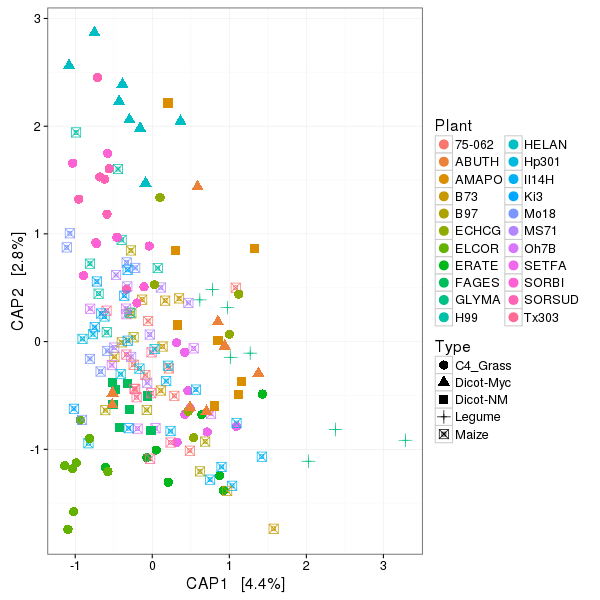

In [55]:
%%R -w 600 -h 600
phy = physeq.Plant

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

cap.plot

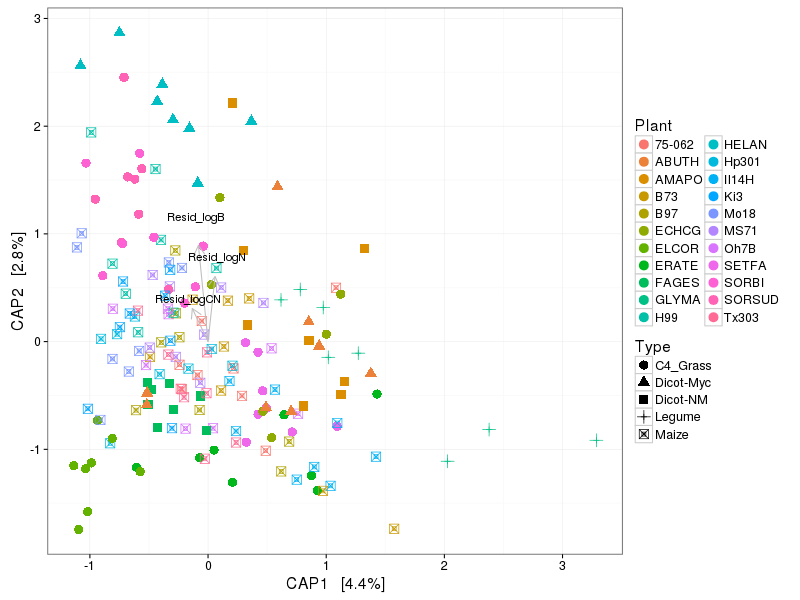

In [56]:
%%R -w 800 -h 600
# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [57]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ Resid_logB + Resid_logN + Resid_logCN, data = data)
          Df SumOfSqs      F Pr(>F)    
Model      3   0.4897 6.1119  0.001 ***
Residual 170   4.5400                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Notes - a small but significant amount of variation in community composition is captured by plant functional variation  

# Analyze by date of sampling 

#### DAP = 72

In [29]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("75-062", "ERATE",  "H99" , "Il14H" , "MS71") & PlantB %in% c("75-062", "ERATE",  "H99" , "Il14H" , "MS71"))
D_dist$PlantComp %>% unique
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)


 [1] "75-062-75-062" "MS71-75-062"   "ERATE-75-062"  "H99-75-062"   
 [5] "Il14H-75-062"  "75-062-MS71"   "MS71-MS71"     "ERATE-MS71"   
 [9] "H99-MS71"      "Il14H-MS71"    "75-062-ERATE"  "MS71-ERATE"   
[13] "ERATE-ERATE"   "H99-ERATE"     "Il14H-ERATE"   "75-062-H99"   
[17] "MS71-H99"      "ERATE-H99"     "H99-H99"       "Il14H-H99"    
[21] "75-062-Il14H"  "MS71-Il14H"    "ERATE-Il14H"   "H99-Il14H"    
[25] "Il14H-Il14H"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r:  0.18 
      Significance: 0.034 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.113 0.159 0.198 0.244 
Permutation: free
Number of permutations: 999



In [31]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "72")
sd = sample_data(physeq.Date)


# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

 [1] "75-062-75-062" "MS71-75-062"   "ERATE-75-062"  "H99-75-062"   
 [5] "Il14H-75-062"  "75-062-MS71"   "MS71-MS71"     "ERATE-MS71"   
 [9] "H99-MS71"      "Il14H-MS71"    "75-062-ERATE"  "MS71-ERATE"   
[13] "ERATE-ERATE"   "H99-ERATE"     "Il14H-ERATE"   "75-062-H99"   
[17] "MS71-H99"      "ERATE-H99"     "H99-H99"       "Il14H-H99"    
[21] "75-062-Il14H"  "MS71-Il14H"    "ERATE-Il14H"   "H99-Il14H"    
[25] "Il14H-Il14H"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.003745 
      Significance: 0.509 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.104 0.135 0.165 0.187 
Permutation: free
Number of permutations: 999



#### Day = 84

In [32]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("HELAN" , "SORBI" , "SORSUD") & PlantB %in% c("HELAN" , "SORBI" , "SORSUD"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

[1] "SORBI-SORBI"   "SORSUD-SORBI"  "HELAN-SORBI"   "SORBI-SORSUD" 
[5] "SORSUD-SORSUD" "HELAN-SORSUD"  "SORBI-HELAN"   "SORSUD-HELAN" 
[9] "HELAN-HELAN"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.6048 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.090 0.125 0.176 0.229 
Permutation: free
Number of permutations: 999



In [33]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "84")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")

#hist(Fun_dist) %>% print

M1 = mantel(Udate, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Udate, ydis = Fun_dist, method = "pearson", permutations = 999) 

Mantel statistic r: -0.1091 
      Significance: 0.933 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0949 0.1332 0.1710 0.2075 
Permutation: free
Number of permutations: 999



#### DAP = 88

In [34]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("ELCOR", "Ki3", "Mo18", "Tx303") & PlantB %in% c("ELCOR", "Ki3", "Mo18", "Tx303"))
    D_dist %>% head() %>% print()
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]


    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

              PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
1 sample8-2.07_Nneg sample8-2.07_Nneg   0.0000000  ELCOR  ELCOR ELCOR-ELCOR
2 sample8-4.23_Nneg sample8-2.07_Nneg   0.1972937    Ki3  ELCOR   Ki3-ELCOR
3 sample8-1.14_Npos sample8-2.07_Nneg   0.2127022  Tx303  ELCOR Tx303-ELCOR
4 sample8-3.28_Npos sample8-2.07_Nneg   0.2195987  Tx303  ELCOR Tx303-ELCOR
5 sample8-2.17_Npos sample8-2.07_Nneg   0.1628086   Mo18  ELCOR  Mo18-ELCOR
6 sample8-2.25_Nneg sample8-2.07_Nneg   0.1472721    Ki3  ELCOR   Ki3-ELCOR
  phy_Dist
1   0.0000
2   0.0509
3   0.0509
4   0.0509
5   0.0509
6   0.0509
 [1] "ELCOR-ELCOR" "Ki3-ELCOR"   "Tx303-ELCOR" "Mo18-ELCOR"  "ELCOR-Ki3"  
 [6] "Ki3-Ki3"     "Tx303-Ki3"   "Mo18-Ki3"    "ELCOR-Tx303" "Ki3-Tx303"  
[11] "Tx303-Tx303" "Mo18-Tx303"  "ELCOR-Mo18"  "Ki3-Mo18"    "Tx303-Mo18" 
[16] "Mo18-Mo18"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 99

In [35]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "88")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1802 
      Significance: 0.029 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.121 0.159 0.187 0.225 
Permutation: free
Number of permutations: 999



# Maize distance analysis

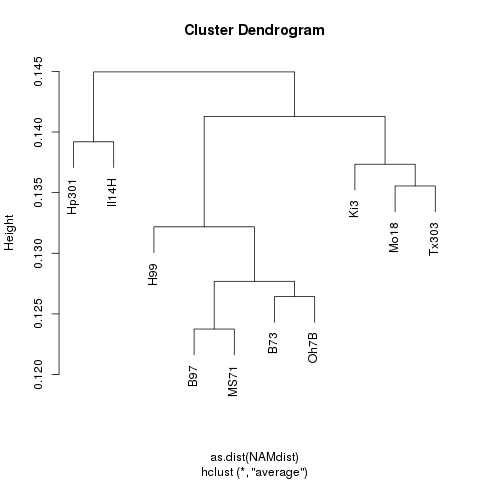

In [26]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [47]:
%%R
physeq.Maize = subset_samples(physeq.Full, Type == "Maize" & Plant != "75-062")
as(sample_data(physeq.Maize), "data.frame") %>%

group_by(Plant) %>%
   summarise(DATE = first(DAP)) %>% 
    arrange(DATE) %>%
   print()

Source: local data frame [10 x 2]

    Plant  DATE
   (fctr) (int)
1     H99    72
2   Il14H    72
3    MS71    72
4     B73    79
5     B97    79
6   Hp301    79
7    Oh7B    79
8     Ki3    88
9    Mo18    88
10  Tx303    88


In [40]:
%%R
#Use melt to join genetic distance matrix with unifrac distance
#head(ud.m) ##Use formated unifrac distance from above
#melt 
NAM.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(NAM.m) = c("PlantA", "PlantB", "gene_Dist")

NAM.m$PlantComp = paste(NAM.m$PlantA, NAM.m$PlantB, sep = "-")
NAM.m %>% head

#Join with unifrac DistanceMatrix
Dist = left_join(ud.m, NAM.m[,c(3,4)], by = "PlantComp")
head(Dist)

              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062 75-062-75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1823763   Oh7B 75-062   Oh7B-75-062
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1619849  SETFA 75-062  SETFA-75-062
4 sample5-2.06_Npos sample5-1.22_Nneg   0.1673805   MS71 75-062   MS71-75-062
5 sample5-4.08_Npos sample5-1.22_Nneg   0.1653478   MS71 75-062   MS71-75-062
6 sample5-4.28_Npos sample5-1.22_Nneg   0.1279704 75-062 75-062 75-062-75-062
  gene_Dist
1        NA
2        NA
3        NA
4        NA
5        NA
6        NA


[1] 30276     7
[1] 30102     7


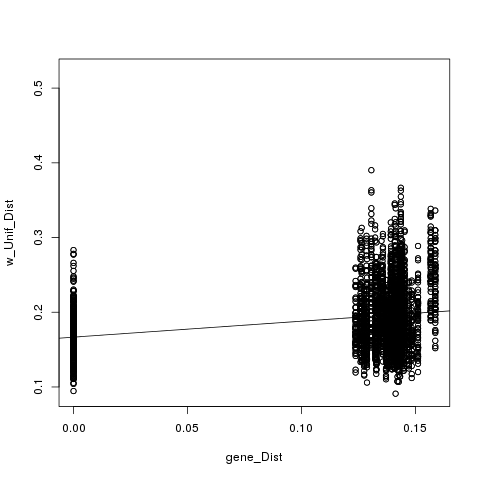

In [42]:
%%R
dim(Dist) %>% print
D.s = filter(Dist, PlotA != PlotB)

dim(D.s) %>% print
plot(w_Unif_Dist~gene_Dist, data = D.s)
m = lm(w_Unif_Dist~gene_Dist, data = D.s)
abline(m) 


In [43]:
%%R
head(Dist)
#Remove NAs to trim dataset
Temp = Dist[!is.na(Dist$gene_Dist),]


#Seperate unifrac and phylogenetic distances retaining plot IDs
U = Temp[,c(1,2,3)]
Gene = Temp[,c(1,2,7)]

#Re-cast longform to wide form.  
Udist = acast(U, PlotA~PlotB) 


Genedist = acast(Gene, PlotA~PlotB)
Genedist

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using gene_Dist as value column: use value.var to override.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                  sample5-1.16_Nneg sample5-1.16_Npos sample5-1.17_Nneg
sample5-1.16_Nneg         0.0000000         0.0000000         0.1328223
sample5-1.16_Npos         0.0000000         0.0000000         0.1328223
sample5-1.17_Nneg         0.1328223         0.1328223         0.0000000
sample5-1.17_Npos         0.1328223         0.1328223         0.0000000
sample5-1.25_Nneg         0.1435944         0.1435944         0.1439733
sample5-1.25_Npos         0.1435944         0.1435944         0.1439733
sample5-2.06_Nneg         0.1328223         0.1328223         0.0000000
sample5-2.06_Npos         0.1328223         0.1328223         0.0000000
sample5-2.11_Nneg         0.0000000         0.0000000         0.1328223
sample5-2.11_Npos         0.0000000         0.0000000         0.1328223
sample5-2.15_Nneg         0.1435944         0.1435944         0.1439733
sample5-2.15_Npos         0.1435944         0.1435944         0.1439733
sample5-3.13_Nneg         0.1328223         0.1328223         0.

In [44]:
%%R
M1 = mantel(as.dist(Genedist), as.dist(Udist), method="pearson", permutations=999)
print(M1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = as.dist(Genedist), ydis = as.dist(Udist), method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1983 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0231 0.0301 0.0344 0.0420 
Permutation: free
Number of permutations: 999



### Functional comparison of maize - Mantel test

In [48]:
%%R
sd = sample_data(physeq.Maize)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
maize.wunif.dist = distance(physeq.Maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(maize.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = maize.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.02211 
      Significance: 0.364 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0751 0.0983 0.1150 0.1431 
Permutation: free
Number of permutations: 999



In test of genetic vs functional control of maize, growth residuals were not significantly correlated with microbial community similarity in mantel test.  Significance was gained by including DAP, however, this is now capturing day to day sampling variation.  

### Functional comparison of maize, CAP

In [51]:
%%R -w 600 -h 600
phy = physeq.Maize

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = maize.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))



[1] 79 72 88
Levels: 72 79 88


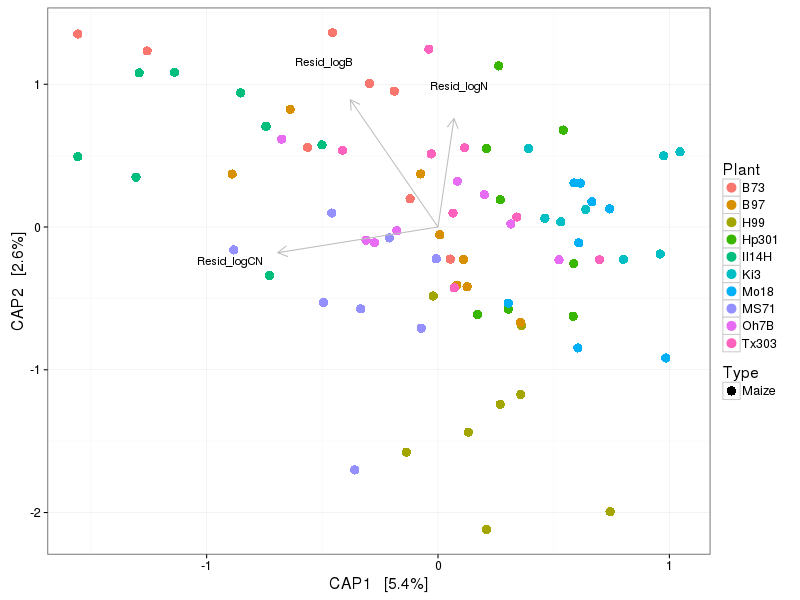

In [52]:
%%R -w 800 -h 600
# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [53]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ Resid_logB + Resid_logN + Resid_logCN, data = data)
         Df SumOfSqs      F Pr(>F)    
Model     3  0.15654 2.7788  0.001 ***
Residual 76  1.42714                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Notes - a small but significant amount of variation in community composition is captured by maize functional variation.  

Check how to constrain by DAP to control for differences from sampling date?  Still significant albeit small portion of variation captured when controlling for DAP.  

### Maize by date

#### DAP = 72

In [54]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("H99" , "Il14H" , "MS71") & PlantB %in% c("H99" , "Il14H" , "MS71"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

[1] "MS71-MS71"   "H99-MS71"    "Il14H-MS71"  "MS71-H99"    "H99-H99"    
[6] "Il14H-H99"   "MS71-Il14H"  "H99-Il14H"   "Il14H-Il14H"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Gene_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.4851 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0629 0.0884 0.1120 0.1441 
Permutation: free
Number of permutations: 999



In [58]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("H99" , "Il14H" , "MS71"))
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.06343 
      Significance: 0.671 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.157 0.211 0.258 0.282 
Permutation: free
Number of permutations: 999



#### DAP = 79

In [65]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B" ) & PlantB %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B"))
 D_dist$PlantComp %>% unique %>% print

#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

 [1] "Oh7B-Oh7B"   "B73-Oh7B"    "B97-Oh7B"    "Hp301-Oh7B"  "Oh7B-B73"   
 [6] "B73-B73"     "B97-B73"     "Hp301-B73"   "Oh7B-B97"    "B73-B97"    
[11] "B97-B97"     "Hp301-B97"   "Oh7B-Hp301"  "B73-Hp301"   "B97-Hp301"  
[16] "Hp301-Hp301"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Gene_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.02775 
      Significance: 0.184 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0440 0.0626 0.0766 0.1062 
Permutation: free
Number of permutations: 999



In [66]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B"))
sd = sample_data(physeq.Date)
D_dist$PlantComp %>% unique %>% print
# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

 [1] "Oh7B-Oh7B"   "B73-Oh7B"    "B97-Oh7B"    "Hp301-Oh7B"  "Oh7B-B73"   
 [6] "B73-B73"     "B97-B73"     "Hp301-B73"   "Oh7B-B97"    "B73-B97"    
[11] "B97-B97"     "Hp301-B97"   "Oh7B-Hp301"  "B73-Hp301"   "B97-Hp301"  
[16] "Hp301-Hp301"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.2259 
      Significance: 0.022 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.121 0.173 0.216 0.256 
Permutation: free
Number of permutations: 999



#### DAP = 88

In [67]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("Ki3" ,  "Mo18" , "Tx303" ) & PlantB %in% c("Ki3" ,  "Mo18" , "Tx303"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

[1] "Ki3-Ki3"     "Tx303-Ki3"   "Mo18-Ki3"    "Ki3-Tx303"   "Tx303-Tx303"
[6] "Mo18-Tx303"  "Ki3-Mo18"    "Tx303-Mo18"  "Mo18-Mo18"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Gene_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.3704 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0681 0.0968 0.1134 0.1467 
Permutation: free
Number of permutations: 999



In [68]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("Ki3" ,  "Mo18" , "Tx303"))
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.01301 
      Significance: 0.448 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.150 0.183 0.214 0.256 
Permutation: free
Number of permutations: 999



# Compare plant phylogenetic distance to l2f

In [ ]:
%%R
# log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
# l2f = read.csv(log2foldFile, header = TRUE)
# colnames(l2f)

### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [ ]:
%%R
# df = l2f[,c(1,11,13)]
# l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
# rownames(l2f_m) = l2f_m$OTU
# l2f_m = l2f_m[,-1]
# l2f_m %>% head

In [ ]:
%%R
# dim(l2f_m)

### recode all negative log2fold changes with 0

In [ ]:
%%R
# l2f_me = l2f_m
# l2f_me[l2f_me < 0] = 0 
# head(l2f_me)

## Calculate pairwise weighted Unifrac distances between samples

need to figure out how to run unifrac measure outside of phyloseq

In [ ]:
%%R
# physeq.Full

In [ ]:
%%R
# #provide fast tree for unifrac calculation
# #treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'
# #Tree = read.tree(treeFile)
# Tree = phy_tree(physeq.Full)
# str(Tree)


In [ ]:
%%R
# l2f_wunif = picante::unifrac(as.matrix(t(l2f_me)), Tree)

In [ ]:
%%R
# l2f_bray = vegdist(as.matrix(t(l2f_me)), method = "bray")

In [ ]:
%%R
# hc_unif = hclust(l2f_wunif, "average")
# plot(hc_unif) %>% print

# hc_bray = hclust(l2f_bray, "average")
# plot(hc_bray, main = "Cluster Dendrogram, \n Bray-Curtis Distance")

# Mantel test of phylogenetic distance and l2f unifrac distance

### Maize

In [ ]:
%%R
# NAMdist %>% print

# #subset column and rows of log2fold change so that only NAM lines are included
# NLU = as.matrix(l2f_wunif)
# NLU = NLU[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLU

# NLB = as.matrix(l2f_bray)
# NLB = NLB[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLB

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLU), method="pearson", permutations=999)
# print(M1)

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLB), method="pearson", permutations=999)
# print(M1)

### Species

In [ ]:
%%R

# #Organize log2fold change distance matrix so that only plants with cholorplast distances are included 
# #and column and row order is congruent with phylogenetic distance matrix
# l2f_wunif.t = as.matrix(l2f_wunif) %>% as.data.frame()
#     temp1 = l2f_wunif.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLU = as.matrix(temp1)

#     SLU = as.dist(SLU)
#     SLU %>% print

# #Remove ginkgo so that matrices are congruent
# p.temp = as.matrix(phydist) %>% as.data.frame()
#     temp2 = p.temp[-12, -12] #remove ginkgo

#     temp2 = as.matrix(temp2)
#     phydist = as.dist(temp2)

#     phydist %>% print

# l2f_bray.t = as.matrix(l2f_bray) %>% as.data.frame()
#     temp2 = l2f_bray.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLB = as.matrix(temp2)
#     SLB = as.dist(SLB)
#     SLB %>% print


In [ ]:
%%R
# m1 = mantel(phydist, SLU, method="pearson", permutations=999)
# print(m1)

In [ ]:
%%R
# m1 = mantel(phydist, SLB, method="pearson", permutations=999)
# print(m1)